# Data Wrangling Udacity Project
### Gather, Assess, and Clean data related to dog ratings
Created by Lukas Peterson - Udacity student

In [8]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import re
from timeit import default_timer as timer

# 1. Gather

### Gather each of the three pieces of data as described:

* The WeRateDogs Twitter archive. CSV file on hand - twitter_archive_enhanced.csv


* The tweet image predictions hosted on Udacity's servers at the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


* Each tweet's retweet count and favorite using the Twitter API


### 1a. Gather the WeRateDogs Twitter archive data from local csv

In [9]:
# Read in the local CSV file
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
df_1.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### 1b. Gather tweet image prediction data from hosted url location

In [14]:
!pwd

/Users/lukas/Box/Analytics/Training and Enablement/Udacity Data Science/Data Wrangling/Wrangling_project


In [15]:
# Open file from the Udacity hosting site
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
folder_name = '/Users/lukas/Box/Analytics/Training and Enablement/Udacity Data Science/Data Wrangling/Wrangling_project'
response = requests.get(url)

with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)



In [16]:
os.listdir(folder_name)

['.ipynb_checkpoints',
 'act_report.html',
 'act_report.ipynb',
 'act_report.pdf',
 'image-predictions.tsv',
 'img',
 'tweet_json.txt',
 'twitter-archive-enhanced.csv',
 'twitter_archive_master.csv',
 'wrangle_act.html',
 'wrangle_act.ipynb',
 'wrangle_report.html']

In [17]:
# Read in the tsv file dowloaded from Udacity server
df_2 = pd.read_csv('image-predictions.tsv', sep='\t')
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1c. Gather tweet metrics from twitter tweepy API

In [18]:
# twitter API credentials, hide for sharing

consumer_key = 'REMOVED FOR SHARING'
consumer_secret = 'REMOVED FOR SHARING'
access_token = 'REMOVED FOR SHARING'
access_secret = 'REMOVED FOR SHARING'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [19]:
# store all tweet IDs to a list

tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

In [1]:
## Query Twitter's API for JSON data for each tweet ID in the Twitter archive
## Commented cell to condense NB
#count = 0
#fails_dict = {}
#start = timer()
## Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
#    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#|print(fails_dict)

In [20]:
# Sample JSON output from Twitter API; understand structure and key names for parsing
tweet = api.get_status(892420643555336193, tweet_mode='extended')
tweet._json

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [21]:
# find the retweet and like count keys
print(tweet._json['retweet_count'])
print(tweet._json['favorite_count'])

7777
36526


In [22]:
# read JSON data to pandas dataframe
df_3 = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as json_file:
    for line in json_file:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df_3 = df_3.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count']))
df_3 = df_3.reset_index(drop=True)
df_3.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7783,36549
1,892177421306343426,5765,31478
2,891815181378084864,3816,23734
3,891689557279858688,7947,39862
4,891327558926688256,8585,38072


# 2. Assess

Visual and programattic assessment of the data quality and tidiness. Issues are documented following the assessment cells

In [24]:
# Visually Assess df_1: twitter archive data
# I use head() here to keep the nb concise but skimmed the entire dataframe by calling df_1, head(), and tail()
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [25]:
# Visually Assess df_2: tweet image predictions
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
# Visually Assess df_3: tweet metrics
df_3.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7783,36549
1,892177421306343426,5765,31478
2,891815181378084864,3816,23734
3,891689557279858688,7947,39862
4,891327558926688256,8585,38072


In [27]:
# programatically assess df_1 column information and completeness 
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [28]:
# programatically assess df_2 column information and completeness 
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [29]:
# programatically assess df_3 column information and completeness 
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
tweet_id          2329 non-null object
retweet_count     2329 non-null object
favorite_count    2329 non-null object
dtypes: object(3)
memory usage: 54.7+ KB


In [30]:
# programmatically assess rating metric 5 number summary statistics
df_1[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


#### Quality (Document 8 data quality issues for cleaning)
- `df_1` some tweets are retweets or replies, not dog ratings (incorrect data)
- `df_1` retweet and reply columns are not needed
- `df_1` missing data expanded_urls
- `df_1` table: Some dog names missing or incorrect
- `df_1` timestamp incorrect datatype, change to datetime
- `df_3` retweet_count, favorite_count incorrect datatype, change to integer
- `df_1`, `df_2` tweet_id column stored as int, we should change to string
- `df_1` source column contains unecessary html tags
- `df_1` some ratings are incorrectly identified from the tweet



#### Tidiness (Document 2 data tidiness issues for cleaning)
- `df_1` archive table has columns for each dog type doggo, floofer, pupper, puppo which should be a single column `dog_type`
- `df_1`, `df_2`, and `df_3` are currently seperate but part of the same observable units and should be merged into one dataset.

# 3. Clean

Clean each of the above documented quality and tidiness issues. The result should be a high quality and tidy master pandas DataFrame `df_clean`

In [31]:
df1_clean = df_1.copy()
df2_clean = df_2.copy()
df3_clean = df_3.copy()

### Tidiness

- `df_1` archive table has columns for each dog type doggo, floofer, pupper, puppo which should be a single column `dog_type`
- `df_1`, `df_2`, and `df_3` are currently seperate but part of the same observable units and should be merged into one dataset.

#### Define

Create one column `dog_type` from columns `doggo`, `floofer`, `pupper`, `puppo`, in `df1_clean`. Then remove the old dog type columns.

#### Code

In [32]:
# create one column dog_type from columns doggo, floofer, pupper, puppo
df1_clean = df1_clean.replace('None', '')

In [33]:
df1_clean['dog_type'] = df1_clean['doggo'].str.cat(df1_clean[['floofer', 'pupper', 'puppo']].astype(str))


In [34]:
df1_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

In [35]:
# seperate multiple dog types in one tweet with commas
df1_clean.loc[df1_clean.dog_type=='doggopupper','dog_type']='doggo,pupper'
df1_clean.loc[df1_clean.dog_type=='doggofloofer','dog_type']='doggo,floofer'
df1_clean.loc[df1_clean.dog_type=='doggopuppo','dog_type']='doggo,puppo'


#### Test

In [36]:
df1_clean['dog_type'].value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: dog_type, dtype: int64

#### Define

Merge and store `df1_clean`, `df2_clean`, `df3_clean` into one master  dataframe, `df_master`. Change tweet_id in df3_clean to type int to complete merge.





#### Code

In [37]:
df3_clean['tweet_id'] = df3_clean['tweet_id'].astype(int)
df_master = df1_clean.merge(df2_clean,on='tweet_id').merge(df3_clean,on='tweet_id')

#### Test

In [38]:
df_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7783,36549
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5765,31478
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3816,23734
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7947,39862
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8585,38072


### Quality

- `df_1` some tweets are retweets or replies, not dog ratings (incorrect data)
- `df_1` retweet and reply columns are not needed
- `df_1` missing data expanded_urls
- `df_1` table: Some dog names missing or incorrect
- `df_1` timestamp incorrect datatype, change to datetime
- `df_3` retweet_count, favorite_count incorrect datatype, change to integer
- `df_1`, `df_2` tweet_id column stored as int, we should change to string
- `df_1` source column contains unecessary html tags
- `df_1` some ratings are incorrectly identified from the tweet


In [39]:
df_clean = df_master.copy()
df_clean.reset_index(inplace=True)
df_clean.head(2)

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7783,36549
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5765,31478


#### Define

Drop rows that contain retweets or replies to other tweets. Retweets and replies can be identified from `in_reply_to_status_id` and `retweeted_status_id` columns having real values.


Then drop the retweet and reply columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`

#### Code

In [40]:
# drop rows with non null values in `in_reply_to_status_id` and `retweeted_status_id`

df_clean.drop(df_clean[df_clean['in_reply_to_status_id'].notna()].index, inplace=True)

df_clean.drop(df_clean[df_clean['retweeted_status_id'].notna()].index, inplace=True)


In [41]:
# drop reply and retweet columns

df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', \
                'retweeted_status_id', 'retweeted_status_user_id', \
                'retweeted_status_timestamp'], axis=1, inplace=True)


#### Test

In [42]:
df_clean.head()

,index,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7783,36549
1,1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5765,31478
2,2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3816,23734
3,3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7947,39862
4,4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8585,38072


#### Define

Drop rows with missing data `expanded_urls`

#### Code

In [43]:
df_clean.dropna(subset=['expanded_urls'], inplace=True)

#### Test

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2056
Data columns (total 23 columns):
index                 1962 non-null int64
tweet_id              1962 non-null int64
timestamp             1962 non-null object
source                1962 non-null object
text                  1962 non-null object
expanded_urls         1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
dog_type              1962 non-null object
jpg_url               1962 non-null object
img_num               1962 non-null int64
p1                    1962 non-null object
p1_conf               1962 non-null float64
p1_dog                1962 non-null bool
p2                    1962 non-null object
p2_conf               1962 non-null float64
p2_dog                1962 non-null bool
p3                    1962 non-null object
p3_conf               1962 non-null float64
p3_dog                1962 non-null boo

#### Define

cast tweet_id column to string

#### Code

In [45]:
df_clean['tweet_id'] = df_clean['tweet_id'].astype(str)

#### Test

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2056
Data columns (total 23 columns):
index                 1962 non-null int64
tweet_id              1962 non-null object
timestamp             1962 non-null object
source                1962 non-null object
text                  1962 non-null object
expanded_urls         1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
dog_type              1962 non-null object
jpg_url               1962 non-null object
img_num               1962 non-null int64
p1                    1962 non-null object
p1_conf               1962 non-null float64
p1_dog                1962 non-null bool
p2                    1962 non-null object
p2_conf               1962 non-null float64
p2_dog                1962 non-null bool
p3                    1962 non-null object
p3_conf               1962 non-null float64
p3_dog                1962 non-null bo

#### Define

Remove HTML tags and keep only the source URL from source column: 
- Split the source string on spaces. Then use string slicing to capture only the source URL from the `source` column

#### Code

In [47]:
df_clean['source'] = df_clean['source'].str.split(' ').str[1].str[6:-1]

#### Test

In [48]:
df_clean['source'].value_counts()

http://twitter.com/download/iphone              1924
http://twitter.com                                28
https://about.twitter.com/products/tweetdeck      10
Name: source, dtype: int64

#### Define

Replace missing or incorrect dog names with empty string

#### Code

In [49]:
missing_name_list = ['a', 'an', 'None', 'quite', 'the', 'such']

df_clean['name'].replace(missing_name_list, '', inplace=True)

#### Test

In [50]:
df_clean['name'].value_counts()

           596
Oliver      10
Charlie     10
Cooper      10
Tucker       9
          ... 
Duchess      1
Champ        1
Maude        1
Pubert       1
Stella       1
Name: name, Length: 927, dtype: int64

#### Define

Change timestamp to pandas datetime datatype

#### Code

In [51]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

#### Test

In [52]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2056
Data columns (total 23 columns):
index                 1962 non-null int64
tweet_id              1962 non-null object
timestamp             1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
expanded_urls         1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
dog_type              1962 non-null object
jpg_url               1962 non-null object
img_num               1962 non-null int64
p1                    1962 non-null object
p1_conf               1962 non-null float64
p1_dog                1962 non-null bool
p2                    1962 non-null object
p2_conf               1962 non-null float64
p2_dog                1962 non-null bool
p3                    1962 non-null object
p3_conf               1962 non-null float64
p3_dog                196

#### Define

Change retweet_count, favorite_count datatypes to integer

#### Code

In [53]:
df_clean[['retweet_count', 'favorite_count']] = df_clean[['retweet_count', 'favorite_count']].astype(int)

#### Test

In [54]:
df_clean.dtypes

index                               int64
tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
dog_type                           object
jpg_url                            object
img_num                             int64
p1                                 object
p1_conf                           float64
p1_dog                               bool
p2                                 object
p2_conf                           float64
p2_dog                               bool
p3                                 object
p3_conf                           float64
p3_dog                               bool
retweet_count                       int64
favorite_count                      int64
dtype: object

#### Define

Create a new column `rating` using string extract and regular expressions to extract the rating from the tweet text. Then correct the `rating_numerator` and `rating_denominator` using string split method and indexing.

#### Code

In [55]:
# Create new column rating, with correct rating extracted with regex

df_clean['rating'] = df_clean['text'].str.extract(r'([0-9]+[0-9.]*/[0-9]+[0-9]*)',expand=False)

In [56]:
df_clean['rating'].head()

0    13/10
1    13/10
2    12/10
3    13/10
4    12/10
Name: rating, dtype: object

In [57]:
# Correct rating_numerator and rating_denominator from our new rating column

df_clean['rating_numerator'] = df_clean['rating'].str.split('/').str[0]
df_clean['rating_denominator'] = df_clean['rating'].str.split('/').str[1]

#### Test

In [58]:
df_clean[['rating', 'rating_numerator', 'rating_denominator']].tail()

,rating,rating_numerator,rating_denominator
2052,5/10,5,10
2053,6/10,6,10
2054,9/10,9,10
2055,7/10,7,10
2056,8/10,8,10


In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2056
Data columns (total 24 columns):
index                 1962 non-null int64
tweet_id              1962 non-null object
timestamp             1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
expanded_urls         1962 non-null object
rating_numerator      1962 non-null object
rating_denominator    1962 non-null object
name                  1962 non-null object
dog_type              1962 non-null object
jpg_url               1962 non-null object
img_num               1962 non-null int64
p1                    1962 non-null object
p1_conf               1962 non-null float64
p1_dog                1962 non-null bool
p2                    1962 non-null object
p2_conf               1962 non-null float64
p2_dog                1962 non-null bool
p3                    1962 non-null object
p3_conf               1962 non-null float64
p3_dog                1

# 4. Store Data

Store the clean data to a master table: twitter_archive_master.csv

In [60]:
df_clean.to_csv('twitter_archive_master.csv', index=False)

# 5. Analyze Data

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [62]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2056
Data columns (total 24 columns):
index                 1962 non-null int64
tweet_id              1962 non-null object
timestamp             1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
expanded_urls         1962 non-null object
rating_numerator      1962 non-null object
rating_denominator    1962 non-null object
name                  1962 non-null object
dog_type              1962 non-null object
jpg_url               1962 non-null object
img_num               1962 non-null int64
p1                    1962 non-null object
p1_conf               1962 non-null float64
p1_dog                1962 non-null bool
p2                    1962 non-null object
p2_conf               1962 non-null float64
p2_dog                1962 non-null bool
p3                    1962 non-null object
p3_conf               1962 non-null float64
p3_dog                1

### 5a. What type of dogs get the most likes on WeRateDogs?

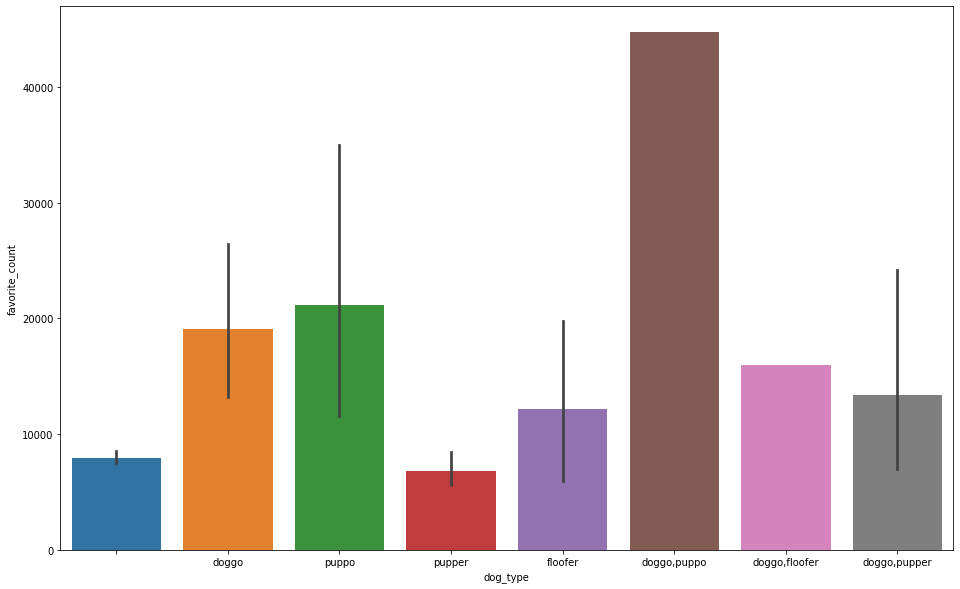

In [63]:
# Plot the favorite count for each dog type

plt.figure(figsize=(16, 10))

sns.barplot(x='dog_type', y='favorite_count', data=df_clean);

**Doggo,Puppo dogs wer favorited the most, over 40,000 likes, followed by puppos and doggos**

### 5b. Which tweets did best by retweets and favorites?

Create a new metric "engagement_score" which is the sum of favorites and retweets to use in analysis

In [64]:
# Create a single metric "engagement_score" as a sum 
# of the retweets and favorites for each tweet

df_clean['engagement_score'] = df_clean['retweet_count'] \
+ df_clean['favorite_count']


In [65]:
# retrieve the top 5 tweets by engagement score

df_clean[['tweet_id', 'text', 'name', 'dog_type', 'engagement_score', 'jpg_url']]\
.nlargest(5, 'engagement_score')

,tweet_id,text,name,dog_type,engagement_score,jpg_url
836,744234799360020481,Here's a doggo realizing you can stand in a po...,,doggo,236645,https://pbs.twimg.com/ext_tw_video_thumb/74423...
423,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,Stephan,,179331,https://pbs.twimg.com/ext_tw_video_thumb/80710...
320,822872901745569793,Here's a super supportive puppo participating ...,,puppo,178956,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
871,739238157791694849,Here's a doggo blowing bubbles. It's downright...,,doggo,174961,https://pbs.twimg.com/ext_tw_video_thumb/73923...
110,866450705531457537,This is Jamesy. He gives a kiss to every other...,Jamesy,pupper,150825,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg


**Tweet: 744234799360020481 was a hit for WeRateDogs, scoring 236,645 likes and retweets**

### 5c. What day of the week on average gets the most likes and retweets?

In [66]:
# create a day of the week column based on the timestamp variable
df_clean['dow']=df_clean['timestamp'].dt.dayofweek

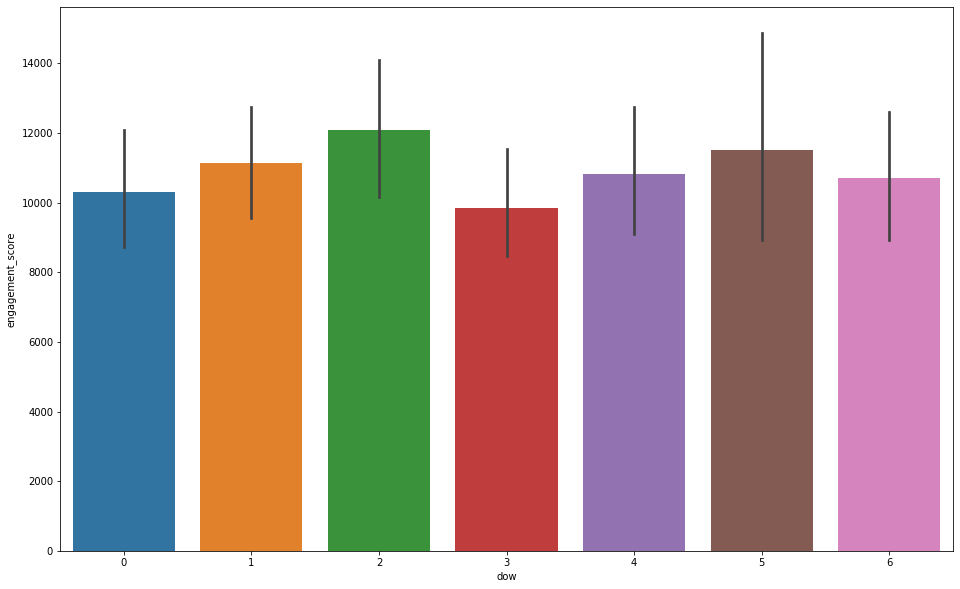

In [67]:
# Plot the engagement score for each day of the week
plt.figure(figsize=(16, 10))

sns.barplot(x='dow', y='engagement_score', data=df_clean);

**Tuesdays get the most engagement in terms of retweets and favorites, Wednesdays have the lowest engagement scores.**

### 5d. What tweet has the highest rating from WeRateDogs?


In [68]:
# create ratio from the rating to sort for highest rated dog
df_clean['rating_ratio'] = df_clean['rating_numerator'].astype(float) / df_clean['rating_denominator'].astype(float)

In [69]:
# Display the top tweet by rating_ratio
df_clean.sort_values(by=['rating_ratio'], ascending=False).head(1)

,index,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,...,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating,engagement_score,dow,rating_ratio
787,787,749981277374128128,2016-07-04 15:00:45+00:00,https://about.twitter.com/products/tweetdeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,,...,False,sunglass,0.050776,False,2487,5192,1776/10,7679,0,177.6


**Atticus from Tweet: 749981277374128128 scored the highest from WeRateDogs with an impressive 1776 out of 10 score.**